In [51]:
import pandas as pd
import ta
from binance.client import Client
import ccxt
import mplfinance as mpf
import numpy as np
from math import floor
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import config

client = Client(config.api_key, config.api_secret)
# Create Binance client instance
exchange = ccxt.binance({
    'apiKey': config.api_key,
    'secret': config.api_secret,
})

In [52]:
# barcha balanslarni korsatadi
# info = client.get_account()
# balans = info['balances']
# for x in balans:
#     if float(x['free']) > 0:
#         print(x)

In [53]:
balance = client.get_asset_balance(asset='USDT')
balance # USDT ga tegishgli balansni korsatadi

{'asset': 'USDT', 'free': '0.39314268', 'locked': '0.00000000'}

In [54]:
# Get latest bitcoin price
btc_price = client.get_symbol_ticker(symbol="BNBUSDT")

# Print the price
print("Bitcoin price: ", btc_price['price'])


Bitcoin price:  321.80000000


In [55]:
# Define symbol and interval
symbol = 'BNBUSDT'
interval = Client.KLINE_INTERVAL_1HOUR

# fetch 30 minute klines for the last month of 2017
klines = client.get_historical_klines(symbol, interval) #, "1 Yan, 2023", "1 Jan, 2025") # vergul qoyib tugash nuqtasini yosa ham boladi , "1 Jan, 2018")

# Convert klines to pandas dataframe
data = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

# Set timestamp as index
data.set_index('timestamp', inplace=True)

# Convert timestamp to datetime format
data.index = pd.to_datetime(data.index, unit='ms')
# data.close_time = pd.to_datetime(data.close_time, unit='ms')

# data type converse float
df = data[['open', 'high', 'low', 'close', 'volume']].astype(float)

df # oxirgi narx

,open,high,low,close,volume
timestamp,,,,,
2023-03-19 19:00:00,339.5,341.0,339.3,339.7,17917.750
2023-03-19 20:00:00,339.7,340.8,335.4,337.1,25653.793
2023-03-19 21:00:00,337.2,339.2,336.3,336.5,10041.989
2023-03-19 22:00:00,336.5,338.7,336.0,338.5,13808.375
2023-03-19 23:00:00,338.6,339.0,335.1,336.7,18879.972
...,...,...,...,...,...
2023-04-30 07:00:00,322.1,322.4,321.5,321.6,5910.864
2023-04-30 08:00:00,321.5,322.4,321.5,322.0,4693.970
2023-04-30 09:00:00,322.1,322.3,321.7,322.1,4611.320


In [56]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

bnb_macd = get_macd(df['close'], 26, 12, 9)

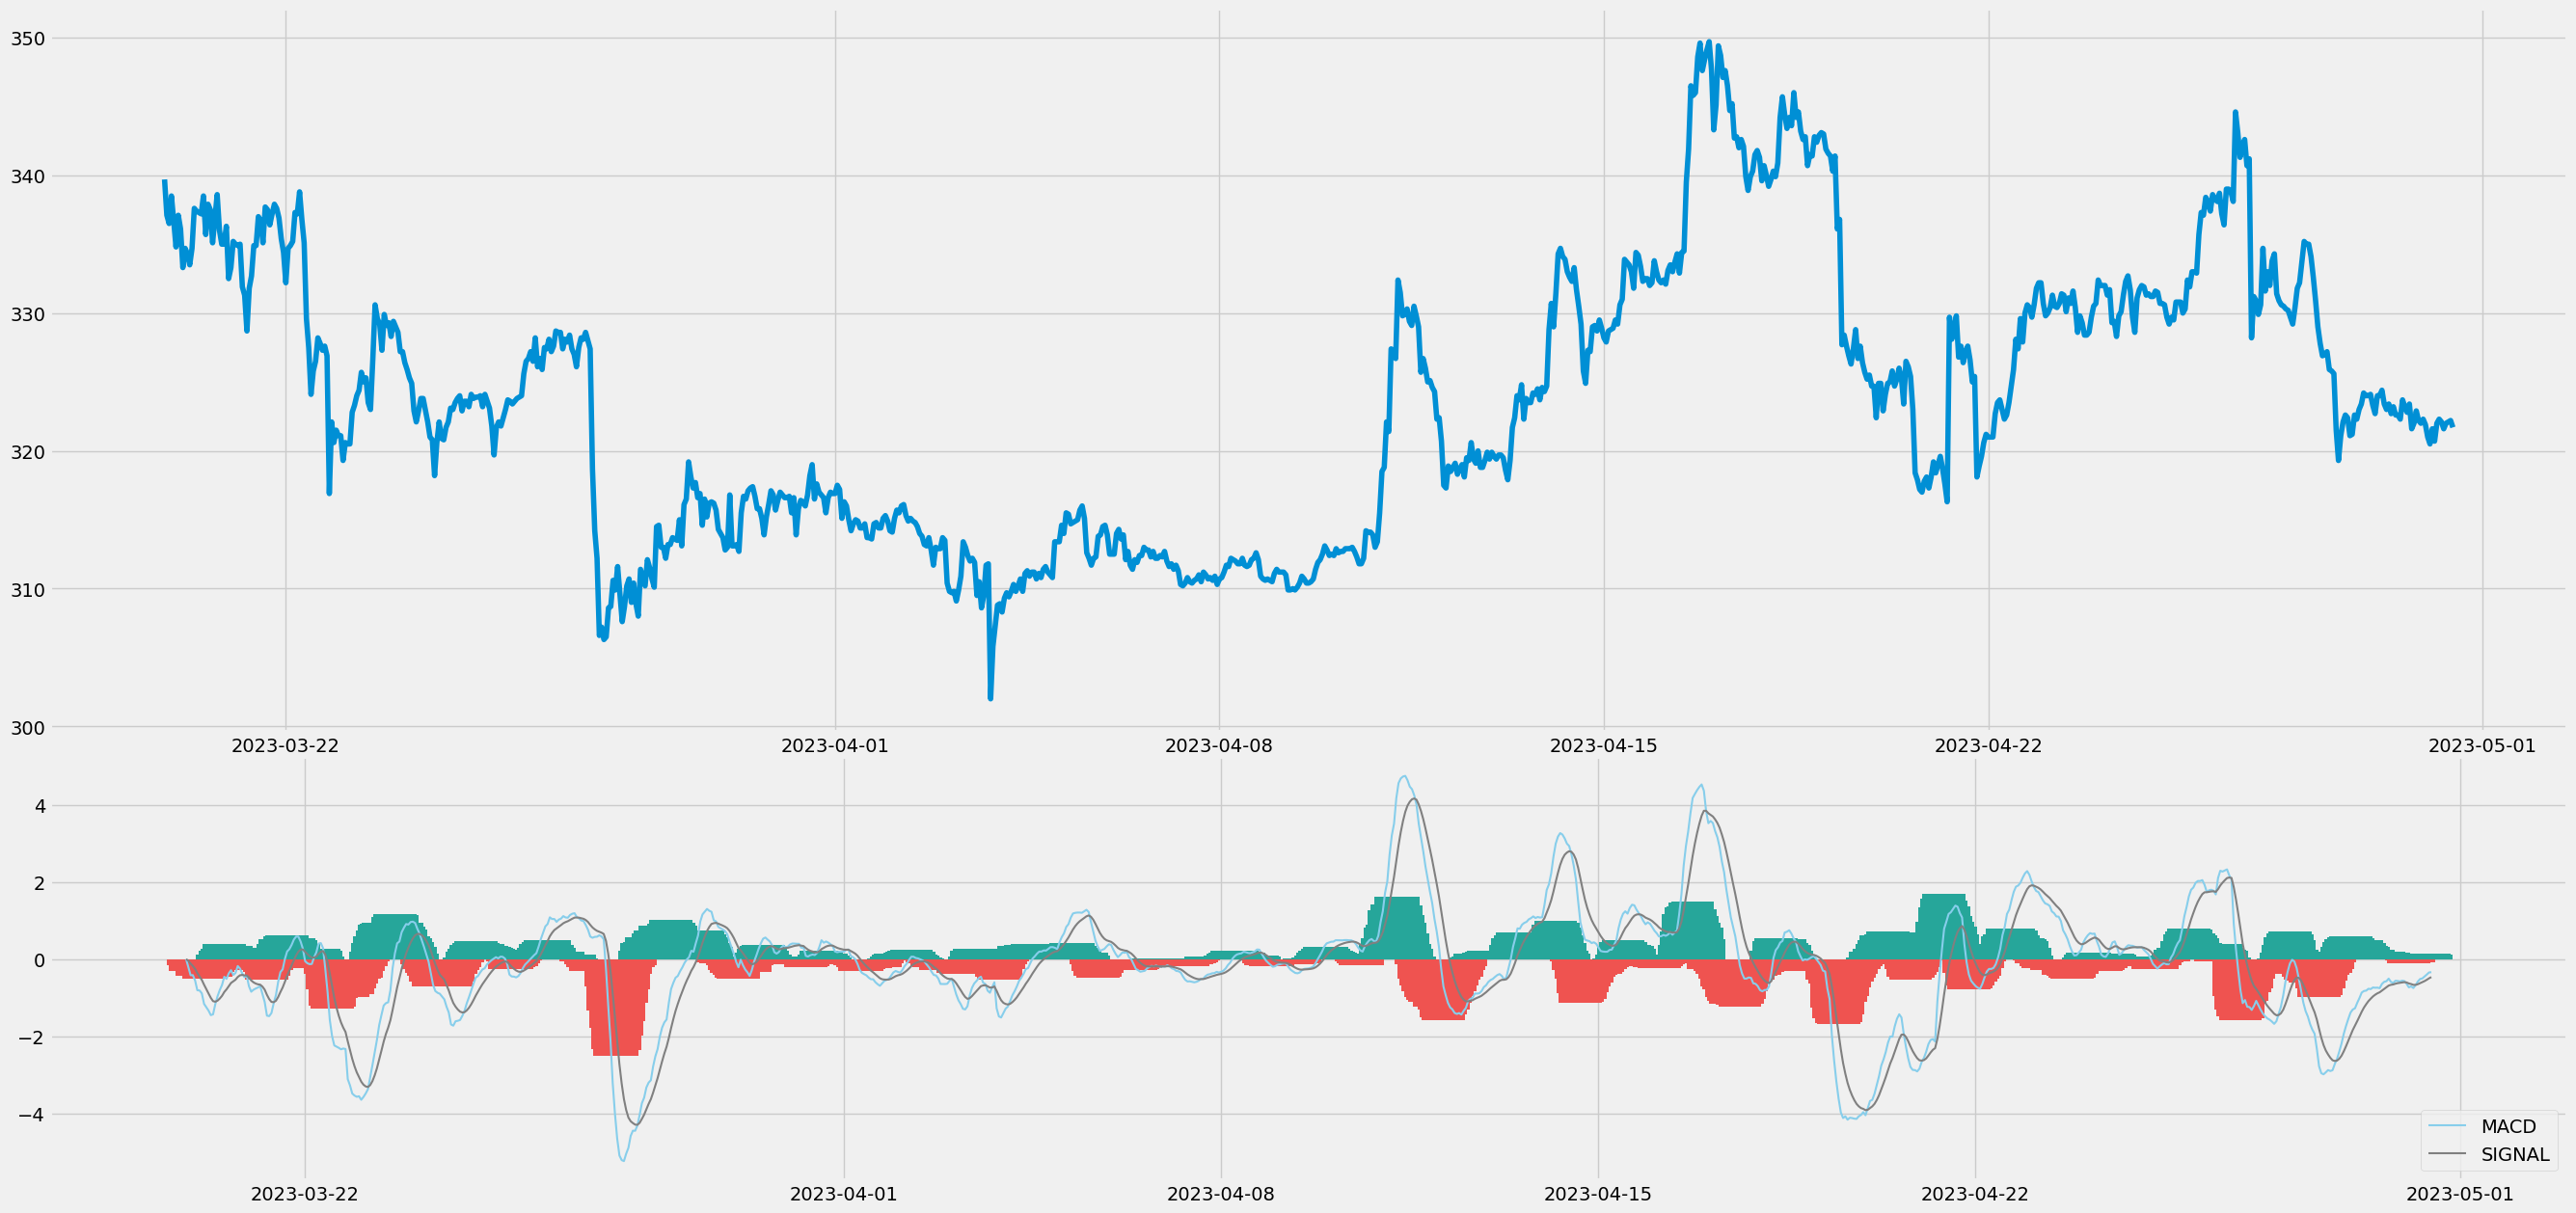

In [57]:
plt.rcParams['figure.figsize'] = (30, 15)
plt.style.use('fivethirtyeight')
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'skyblue', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'grey', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(df['close'], bnb_macd['macd'], bnb_macd['signal'], bnb_macd['hist'])

In [58]:
def implement_macd_strategy(prices, data):
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)

    return buy_price, sell_price, macd_signal

buy_price, sell_price, macd_signal = implement_macd_strategy(df['close'], bnb_macd)

In [59]:
signals = pd.DataFrame({"buy_price": buy_price, "sell_price": sell_price, "macd_signal": macd_signal})
signals

,buy_price,sell_price,macd_signal
0,NaN,NaN,0
1,NaN,337.1,-1
2,NaN,NaN,0
3,NaN,NaN,0
4,NaN,NaN,0
...,...,...,...
995,NaN,NaN,0
996,NaN,NaN,0
997,NaN,NaN,0
998,NaN,NaN,0


In [60]:
df.to_csv("BNB_df.csv")
bnb_macd.to_csv("BNB_macd.csv")
signals.to_csv("Singanls.csv")

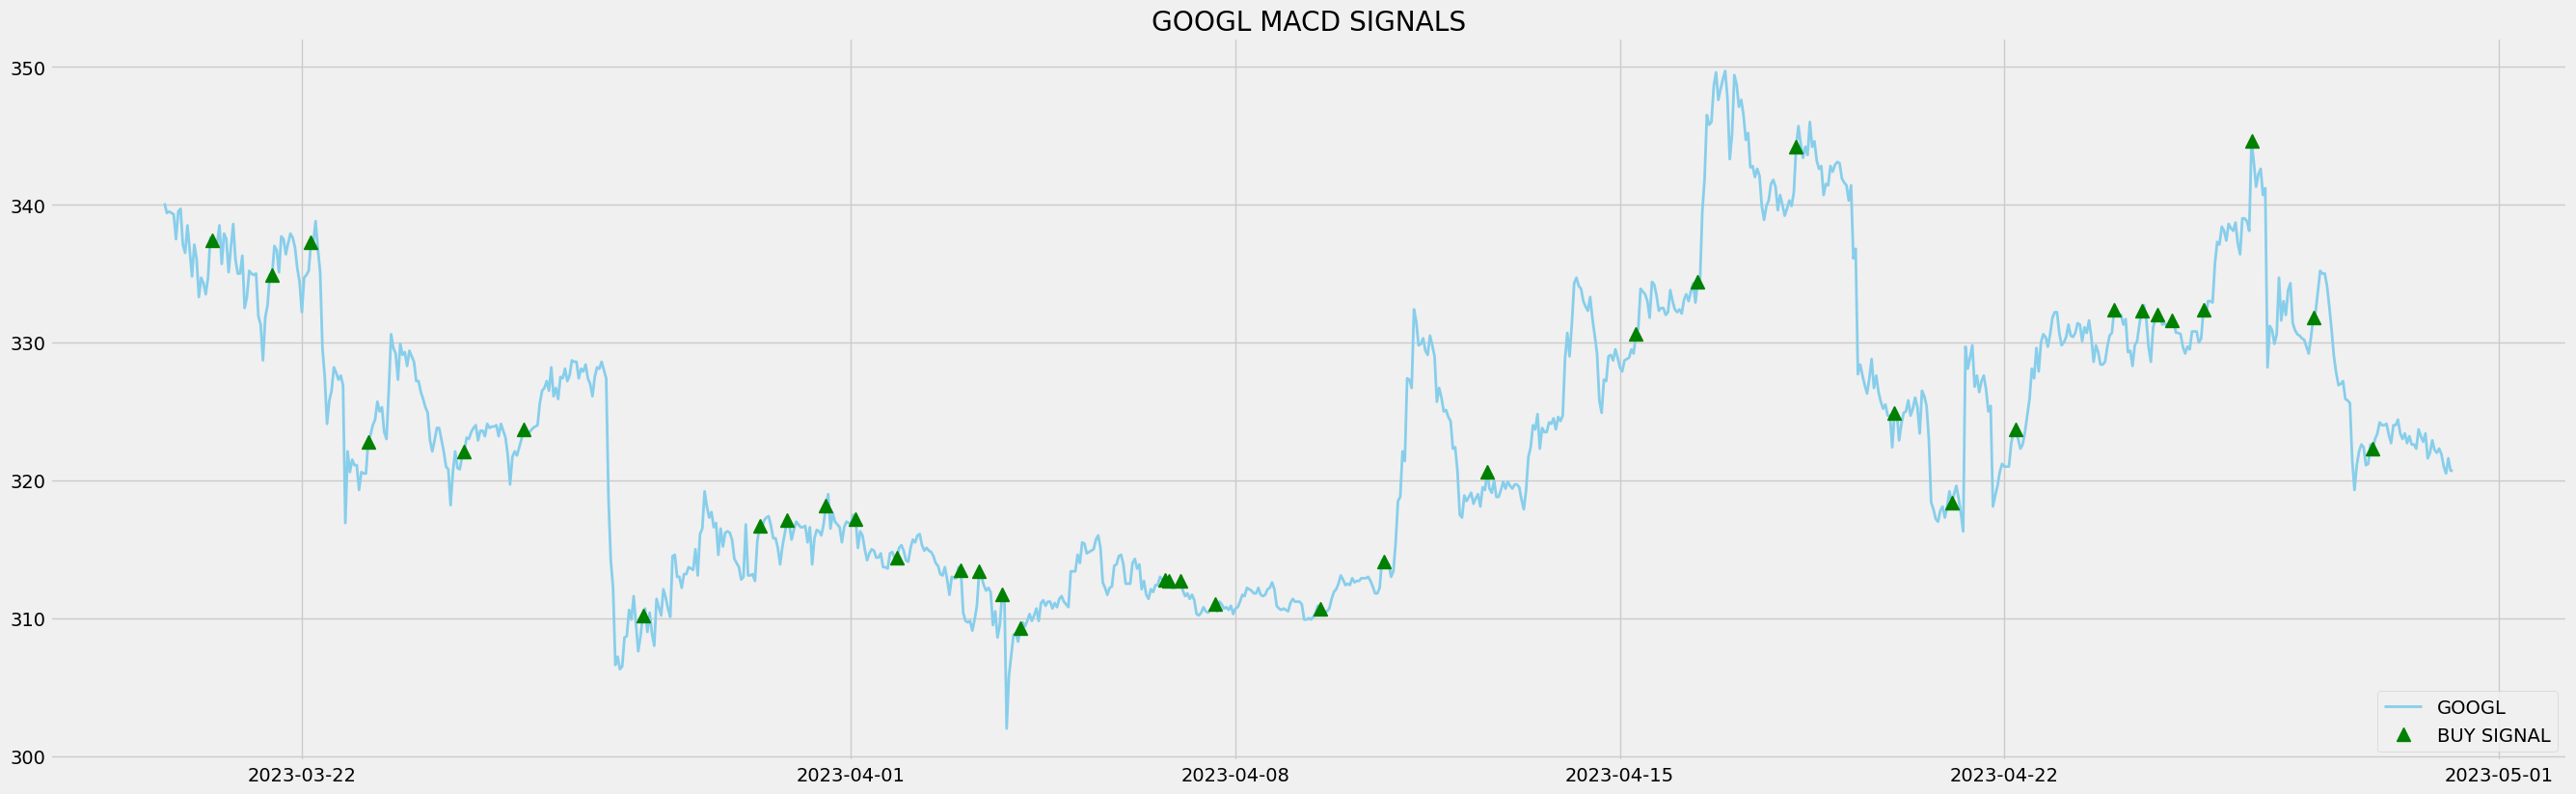

In [25]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
# ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(df['close'], color = 'skyblue', linewidth = 2, label = 'GOOGL')
ax1.plot(df.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
# ax1.plot(df.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('GOOGL MACD SIGNALS')
# ax2.plot(bnb_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
# ax2.plot(bnb_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')
#
# for i in range(len(bnb_macd)):
#     if str(bnb_macd['hist'][i])[0] == '-':
#         ax2.bar(bnb_macd.index[i], bnb_macd['hist'][i], color = '#ef5350')
#     else:
#         ax2.bar(bnb_macd.index[i], bnb_macd['hist'][i], color = '#26a69a')

plt.legend(loc = 'lower right')
plt.show()